In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error, r2_score
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [2]:
Data = pd.read_excel("QBO Data.xlsx")
Data['Date'] = pd.to_datetime(Data['Date'], format='%d%m%Y')
Data.set_index('Date', inplace=True)

data = Data[['25 hPa']]  # Ini penting: index datetime tetap dipertahankan

In [3]:
data.head()

,25 hPa
Date,
1987-01-01,-289
1987-02-01,-280
1987-03-01,-309
1987-04-01,-303
1987-05-01,-289


In [4]:
data.shape

(419, 1)

In [5]:
data.columns

Index(['25 hPa'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 1987-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   25 hPa  419 non-null    int64
dtypes: int64(1)
memory usage: 6.5 KB


In [7]:
# 1. Load Data
data_df = pd.read_excel('QBO Data.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d/%m/%Y')
data_df.set_index('Date', inplace=True)
residuals = data_df['25 hPa'].values.astype(float)

In [8]:
# 2. Sequence Creation (FULL data)
SEQ_LEN = 28
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data)-seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

X, y = create_sequences(residuals, SEQ_LEN)

In [9]:
# 3. Train-test split (no shuffle, preserve time order)
split = int(len(X)*0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# 4. Scaling (fit ONLY on train)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

In [11]:
# 5. Convert to tensor
X_train_tensor = torch.from_numpy(X_train_scaled).float().unsqueeze(-1)
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float().unsqueeze(-1)
y_test_tensor = torch.from_numpy(y_test_scaled).float()

In [12]:
# 6. DataLoader (NO shuffle)
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# 7. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [14]:
# 8. Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, d_model=64, nhead=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_linear(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]
        out = self.decoder(output)
        return out.squeeze(-1)

In [15]:
# 9. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
# 10. Training Loop with Early Stopping
EPOCHS = 200
train_losses = []
test_losses = []
best_r2 = -np.inf
patience = 15
wait = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Eval
    model.eval()
    with torch.no_grad():
        test_loss = 0
        preds = []
        targets = []
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            preds.append(output.cpu().numpy())
            targets.append(yb.cpu().numpy())
            test_loss += criterion(output, yb).item() * xb.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        preds = np.concatenate(preds)
        targets = np.concatenate(targets)
        r2 = r2_score(targets, preds)
        # Early stopping
        if r2 > best_r2:
            best_r2 = r2
            wait = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            wait += 1
        if wait > patience:
            print(f"Early stopped at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test R2: {r2:.4f}')

Epoch 1/200, Train Loss: 0.5756, Test Loss: 0.1979, Test R2: 0.8150
Epoch 10/200, Train Loss: 0.0793, Test Loss: 0.0814, Test R2: 0.9239
Early stopped at epoch 20


In [17]:
# 11. Load best model and Evaluate
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
with torch.no_grad():
    # Train predictions
    train_preds = []
    train_targets = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        train_preds.append(pred.cpu().numpy())
        train_targets.append(yb.cpu().numpy())
    train_preds = np.concatenate(train_preds)
    train_targets = np.concatenate(train_targets)

    # Test predictions
    test_preds = []
    test_targets = []
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        test_preds.append(pred.cpu().numpy())
        test_targets.append(yb.cpu().numpy())
    test_preds = np.concatenate(test_preds)
    test_targets = np.concatenate(test_targets)

# Inverse scaling
y_train_inv = scaler_y.inverse_transform(train_targets.reshape(-1,1)).flatten()
train_preds_inv = scaler_y.inverse_transform(train_preds.reshape(-1,1)).flatten()
y_test_inv = scaler_y.inverse_transform(test_targets.reshape(-1,1)).flatten()
test_preds_inv = scaler_y.inverse_transform(test_preds.reshape(-1,1)).flatten()

In [18]:
# 12. Metric
print("\nTrain Metrics:")
print("Train MSE:", mean_squared_error(y_train_inv, train_preds_inv))
print("Train MAE:", mean_absolute_error(y_train_inv, train_preds_inv))
print("Train R2:", r2_score(y_train_inv, train_preds_inv))

print("\nTest Metrics:")
print("Test MSE:", mean_squared_error(y_test_inv, test_preds_inv))
print("Test MAE:", mean_absolute_error(y_test_inv, test_preds_inv))
print("Test R2:", r2_score(y_test_inv, test_preds_inv))

from sklearn.metrics import mean_squared_error

# Calculate RMSE for training data
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_preds_inv))

# Calculate RMSE for testing data
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))

# Print the results
print("\nRMSE Metrics:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Alternatively, you can create a function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Using the function
train_rmse_func = calculate_rmse(y_train_inv, train_preds_inv)
test_rmse_func = calculate_rmse(y_test_inv, test_preds_inv)

print("\nRMSE Using Function:")
print(f"Train RMSE: {train_rmse_func:.4f}")
print(f"Test RMSE: {test_rmse_func:.4f}")


Train Metrics:
Train MSE: 3146.8071
Train MAE: 37.00882
Train R2: 0.9157621264457703

Test Metrics:
Test MSE: 2940.7695
Test MAE: 37.075306
Test R2: 0.9263918399810791

RMSE Metrics:
Train RMSE: 56.0964
Test RMSE: 54.2289

RMSE Using Function:
Train RMSE: 56.0964
Test RMSE: 54.2289


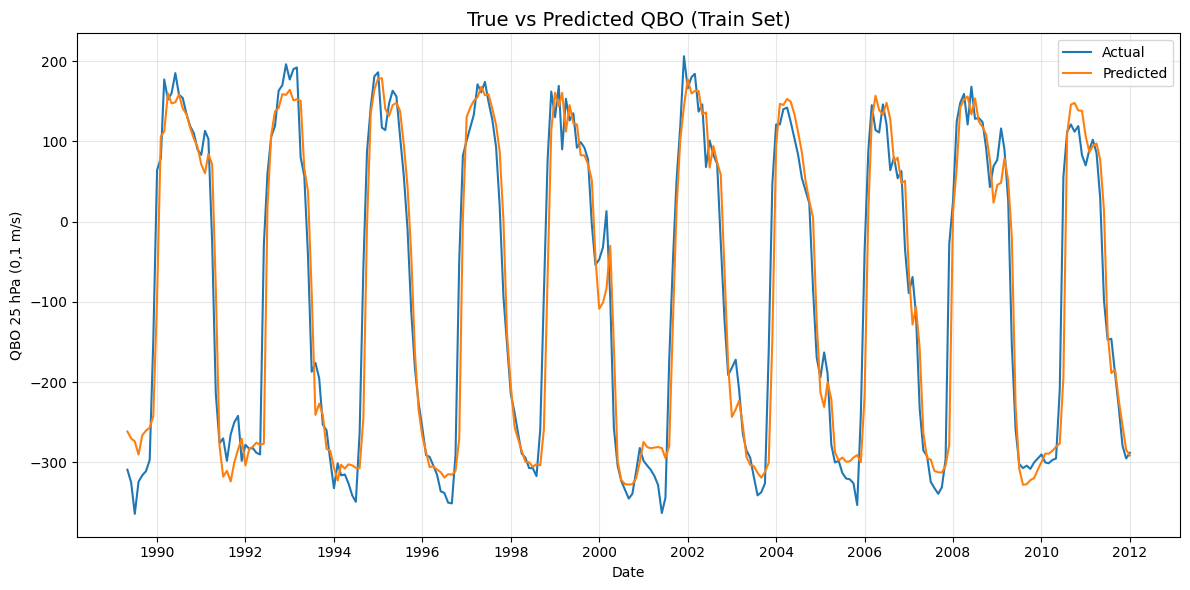

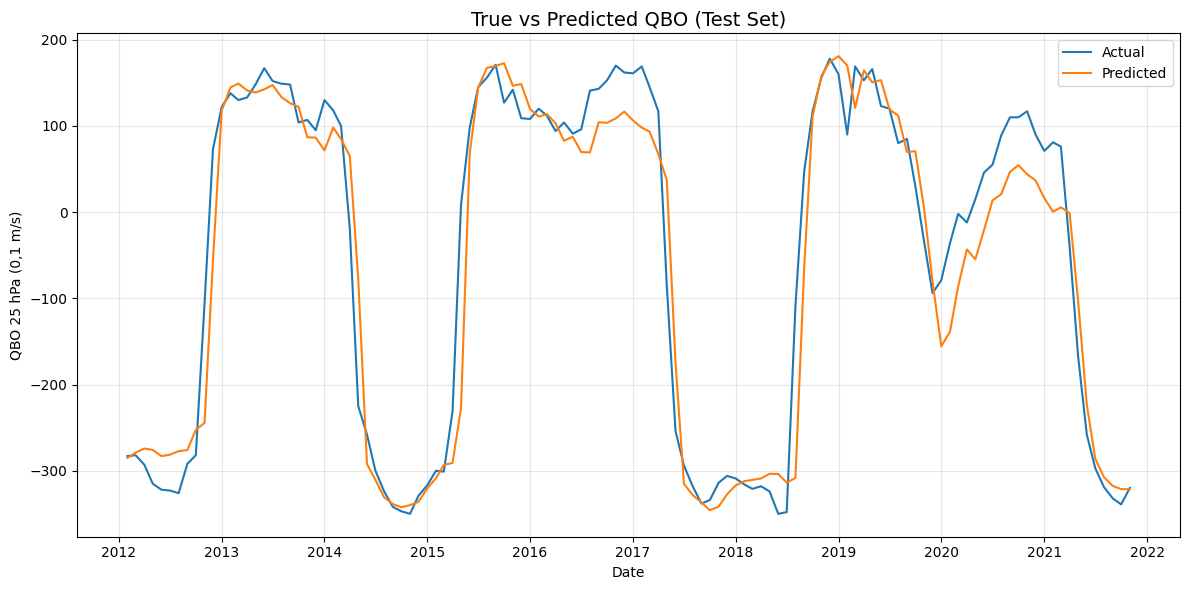

In [37]:
import matplotlib.dates as mdates

# Ambil tanggal hasil sequence (karena dimulai dari SEQ_LEN)
all_dates = data_df.index[SEQ_LEN:]
train_dates = all_dates[:len(y_train_inv)]
test_dates = all_dates[len(y_train_inv):]

# Plot Train Set
plt.figure(figsize=(12,6))
plt.plot(train_dates, y_train_inv, label='Actual')
plt.plot(train_dates, train_preds_inv, label='Predicted')
plt.title('True vs Predicted QBO (Train Set)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('QBO 25 hPa (0,1 m/s)')
plt.legend()

# Format x-axis: per 3 tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Test Set
plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, test_preds_inv, label='Predicted')
plt.title('True vs Predicted QBO (Test Set)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('QBO 25 hPa (0,1 m/s)')
plt.legend()

# Format x-axis: per 3 tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

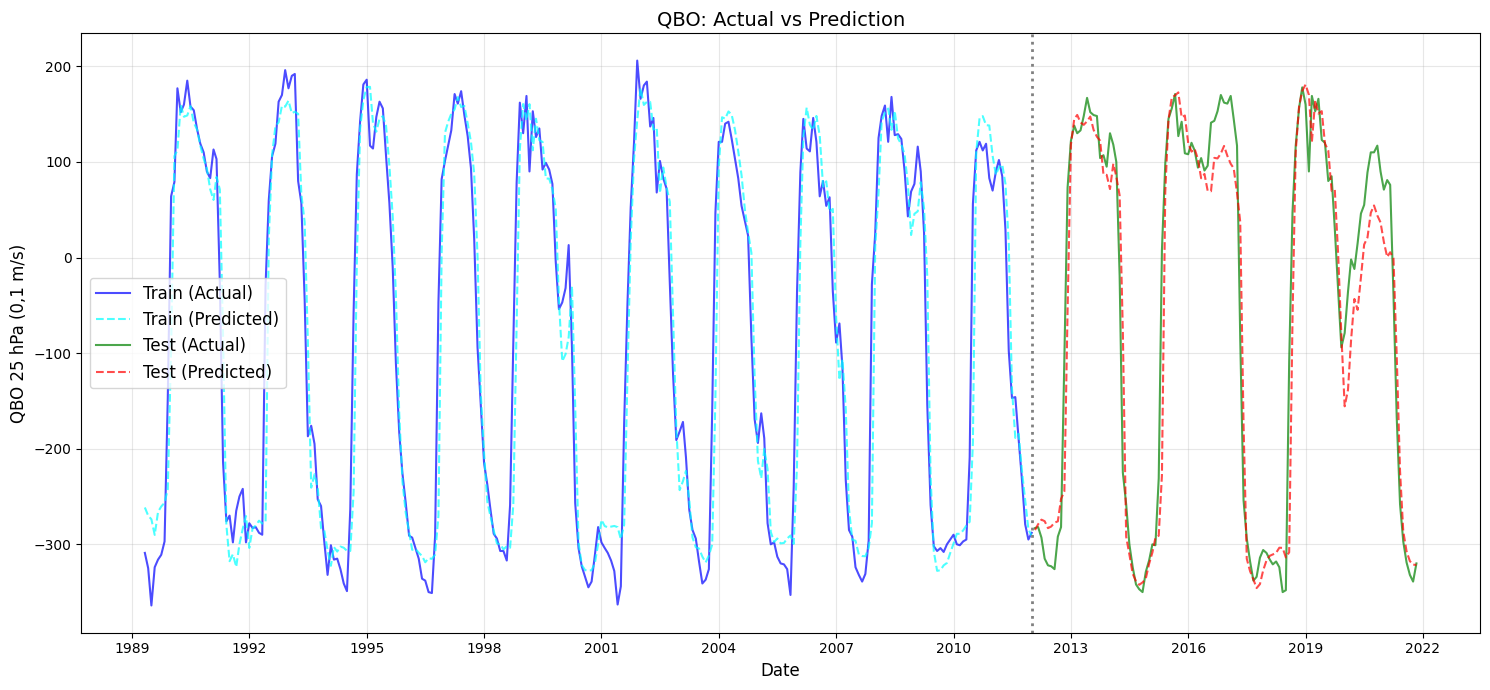

In [32]:
# 14. Combined Plot of Train, Test, and Predictions (dengan sumbu x = Date)
plt.figure(figsize=(15, 7))

# Ambil indeks tanggal dari data asli
all_dates = data_df.index[SEQ_LEN:]  # karena X dan y dibuat mulai dari SEQ_LEN

# Ambil tanggal yang sesuai dengan train dan test
train_dates = all_dates[:len(y_train_inv)]
test_dates = all_dates[len(y_train_inv):]

# Plot training data
plt.plot(train_dates, y_train_inv, label='Train (Actual)', color='blue', alpha=0.7)
plt.plot(train_dates, train_preds_inv, label='Train (Predicted)', color='cyan', linestyle='--', alpha=0.7)

# Plot test data
plt.plot(test_dates, y_test_inv, label='Test (Actual)', color='green', alpha=0.7)
plt.plot(test_dates, test_preds_inv, label='Test (Predicted)', color='red', linestyle='--', alpha=0.7)

# Add vertical line to separate train and test
plt.axvline(x=train_dates[-1], color='gray', linestyle=':', linewidth=2)

# Labels dan Title
plt.title('QBO: Actual vs Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('QBO 25 hPa (0,1 m/s)', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis jadi tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_11392\3914820033.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


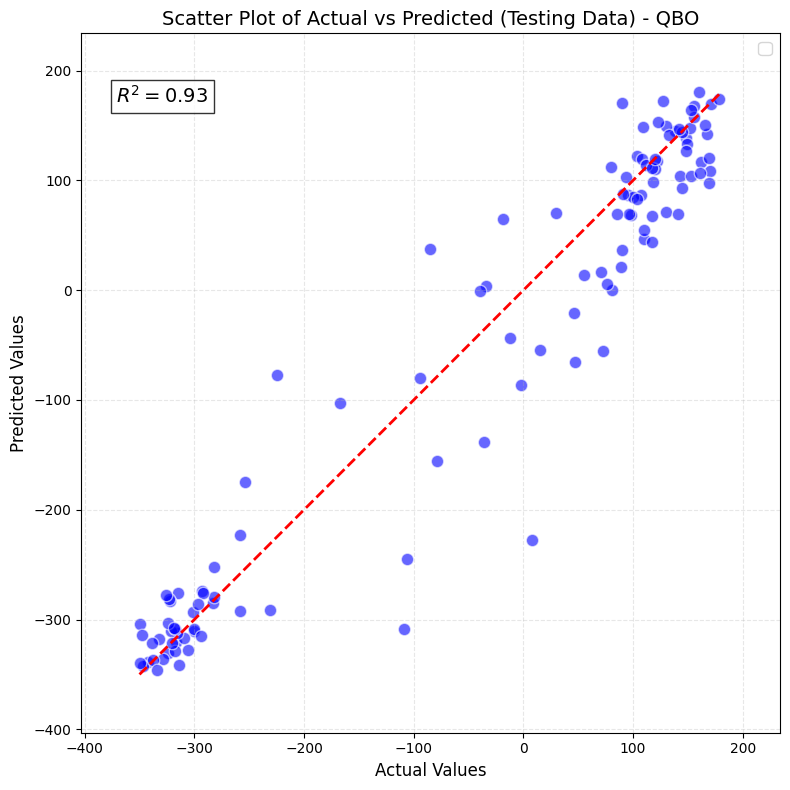

In [33]:
# 15. Scatter Plot of Actual vs Predicted (Test Data)
plt.figure(figsize=(8, 8))

# Create scatter plot
plt.scatter(y_test_inv, test_preds_inv, alpha=0.6, color='blue', edgecolors='w', s=80)

# Add identity line (perfect predictions)
max_val = max(np.max(y_test_inv), np.max(test_preds_inv))
min_val = min(np.min(y_test_inv), np.min(test_preds_inv))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

# Calculate R-squared
r2 = r2_score(y_test_inv, test_preds_inv)

# Add R-squared text annotation
plt.text(0.05, 0.9, f'$R^2 = {r2:.2f}$', transform=plt.gca().transAxes, 
         fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Set labels and title
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Scatter Plot of Actual vs Predicted (Testing Data) - QBO', fontsize=14)

# Set equal axis limits
buffer = 0.1 * (max_val - min_val)
plt.xlim(min_val - buffer, max_val + buffer)
plt.ylim(min_val - buffer, max_val + buffer)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [22]:
# 16. Forecasting Future Residuals
n_forecast = 12  # misalnya forecast 12 bulan ke depan
forecast_inputs = residuals[-SEQ_LEN:].copy()  # ambil SEQ_LEN terakhir dari data asli (belum diskalakan)

# Forecasting container
forecasted = []

model.eval()
with torch.no_grad():
    for _ in range(n_forecast):
        # scale input
        input_seq = scaler_X.transform(forecast_inputs.reshape(1, -1))
        input_tensor = torch.from_numpy(input_seq).float().unsqueeze(-1).to(device)  # shape [1, SEQ_LEN, 1]
        
        # predict
        next_pred_scaled = model(input_tensor).cpu().numpy().flatten()[0]
        next_pred = scaler_y.inverse_transform([[next_pred_scaled]])[0, 0]

        # append prediction
        forecasted.append(next_pred)
        
        # update input for next step
        forecast_inputs = np.append(forecast_inputs[1:], next_pred)

# Print forecasted results
print("\nFuture Forecasted Residuals:")
for i, val in enumerate(forecasted, 1):
    print(f"Step {i}: {val:.4f}")


Future Forecasted Residuals:
Step 1: -307.6002
Step 2: -295.0383
Step 3: -280.1509
Step 4: -263.7178
Step 5: -246.1528
Step 6: -227.4505
Step 7: -206.7591
Step 8: -182.8929
Step 9: -154.5879
Step 10: -121.2886
Step 11: -82.2427
Step 12: -39.2316


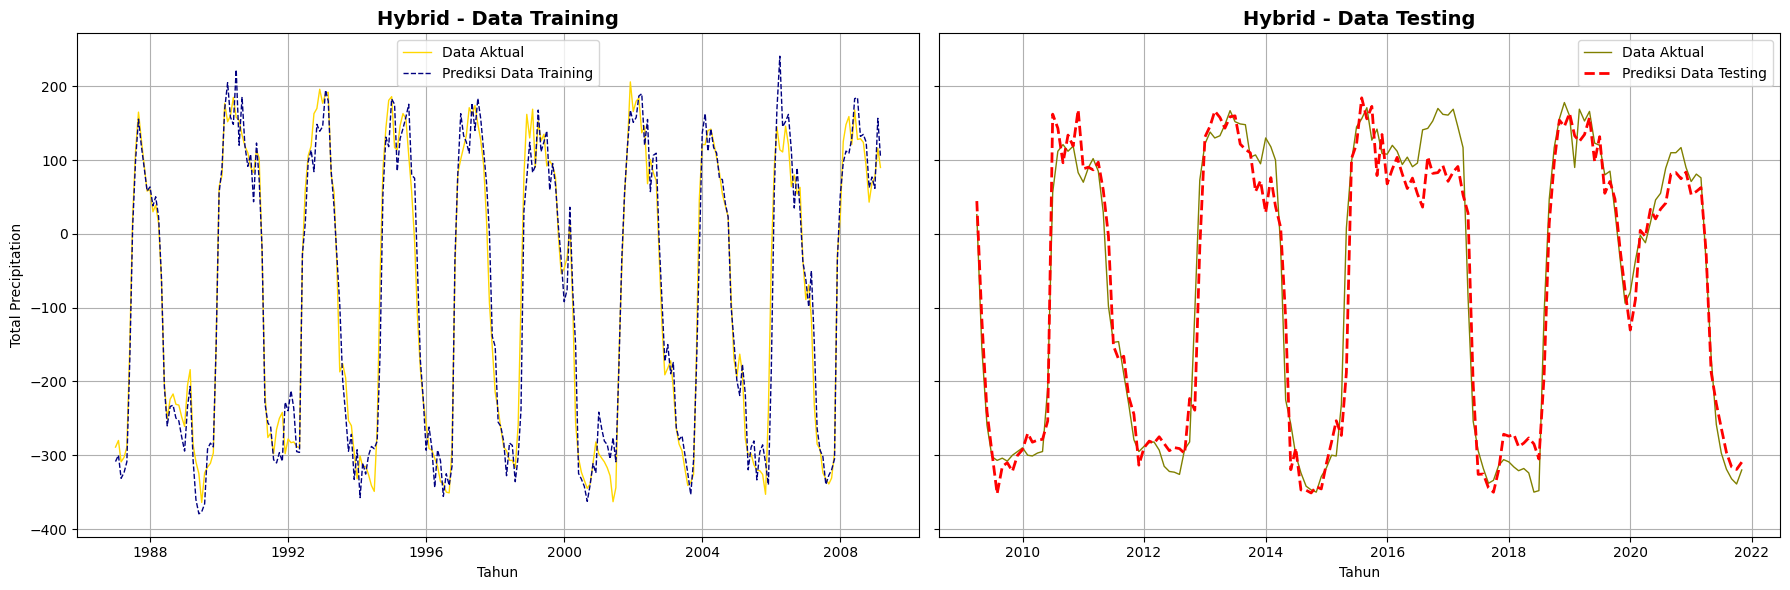

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data Excel
df = pd.read_excel("hasil_hybrid.xlsx")  # Ganti nama file dengan benar
df['Date'] = pd.to_datetime(df['Date'])

# 2. Bagi menjadi training dan testing
df_train = df.iloc[:267].copy()
df_test = df.iloc[267:].copy()

# 3. Plot
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# ---- GRAFIK TRAINING ----
axs[0].plot(df_train['Date'], df_train['Actual'], label='Data Aktual', color='gold', linewidth=1)
axs[0].plot(df_train['Date'], df_train['Hybrid'], label='Prediksi Data Training', color='navy', linestyle='--', linewidth=1)
axs[0].set_title('Hybrid - Data Training', fontsize=14, weight='bold')
axs[0].set_xlabel('Tahun')
axs[0].set_ylabel('Total Precipitation')
axs[0].legend()
axs[0].grid(True)

# ---- GRAFIK TESTING ----
axs[1].plot(df_test['Date'], df_test['Actual'], label='Data Aktual', color='olive', linewidth=1)
axs[1].plot(df_test['Date'], df_test['Hybrid'], label='Prediksi Data Testing', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Hybrid - Data Testing', fontsize=14, weight='bold')
axs[1].set_xlabel('Tahun')
axs[1].legend()
axs[1].grid(True)

# Format
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Load data
df = pd.read_excel("hasil_hybrid.xlsx")  # Ganti dengan nama file kamu
df['Date'] = pd.to_datetime(df['Date'])

# 2. Split data
df_train = df.iloc[:267].copy()
df_test = df.iloc[267:].copy()

# 3. Hitung metrik
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Training
mse_train, mae_train, rmse_train, r2_train = evaluate_metrics(df_train['Actual'], df_train['Hybrid'])

# Testing
mse_test, mae_test, rmse_test, r2_test = evaluate_metrics(df_test['Actual'], df_test['Hybrid'])

# 4. Print hasil
print("=== Hybrid - Data Training ===")
print(f"MSE   : {mse_train:.4f}")
print(f"MAE   : {mae_train:.4f}")
print(f"RMSE  : {rmse_train:.4f}")
print(f"R²    : {r2_train:.4f}")

print("\n=== Hybrid - Data Testing ===")
print(f"MSE   : {mse_test:.4f}")
print(f"MAE   : {mae_test:.4f}")
print(f"RMSE  : {rmse_test:.4f}")
print(f"R²    : {r2_test:.4f}")


=== Hybrid - Data Training ===
MSE   : 1434.6572
MAE   : 28.2445
RMSE  : 37.8769
R²    : 0.9611

=== Hybrid - Data Testing ===
MSE   : 1927.5432
MAE   : 32.3117
RMSE  : 43.9038
R²    : 0.9503


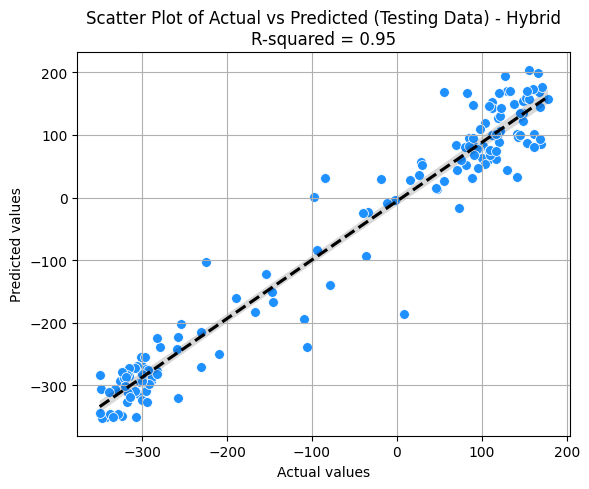

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

# 1. Load data
df = pd.read_excel("hasil_hybrid.xlsx")  # Ganti dengan nama file kamu
df['Date'] = pd.to_datetime(df['Date'])

# 2. Split data
df_test = df.iloc[267:].copy()

# 3. Hitung R-squared
r2 = r2_score(df_test['Actual'], df_test['Predicted'])

# 4. Plot scatter
plt.figure(figsize=(6, 5))
sns.scatterplot(x='Actual', y='Predicted', data=df_test, color='dodgerblue', s=50)
sns.regplot(x='Actual', y='Predicted', data=df_test, scatter=False, color='black', line_kws={"linestyle": "--"})

plt.title(f"Scatter Plot of Actual vs Predicted (Testing Data) - Hybrid\nR-squared = {r2:.2f}")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.grid(True)
plt.tight_layout()
plt.show()


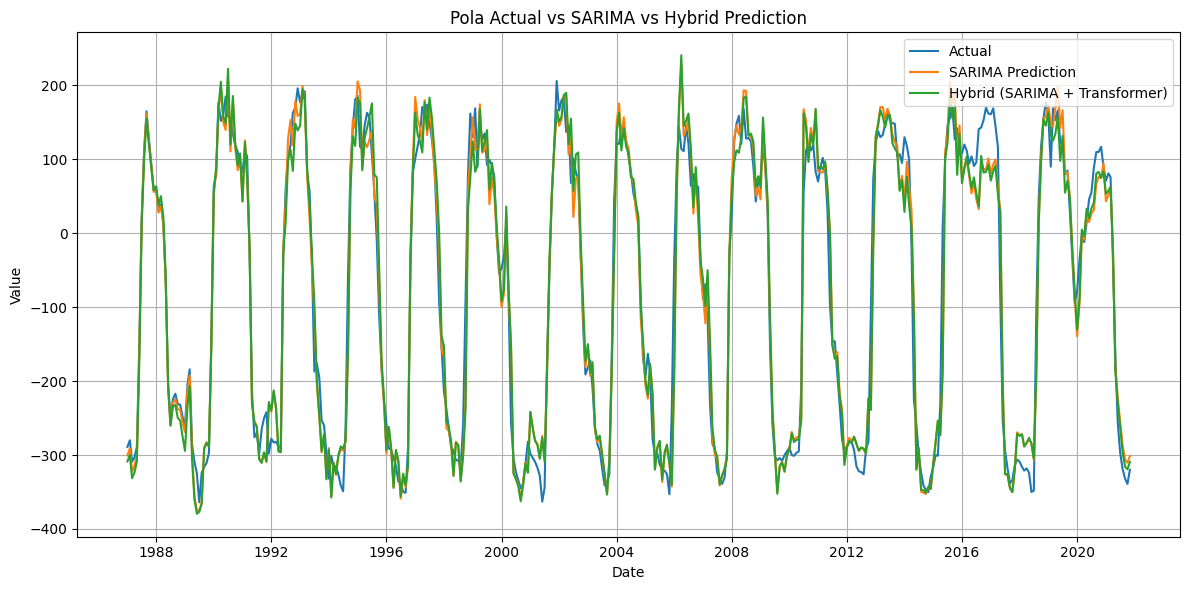

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data dari Excel
df = pd.read_excel("hasil_hybrid.xlsx")  # Ganti nama file sesuai file kamu

# 2. Hitung prediksi hybrid jika belum ada
# df['Hybrid'] = df['SARIMA'] + df['Residual']

# 3. Ubah kolom tanggal jadi datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 4. Plot semua pola
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Actual'], label='Actual')
plt.plot(df['Date'], df['Predicted'], label='SARIMA Prediction')
plt.plot(df['Date'], df['Hybrid'], label='Hybrid (SARIMA + Transformer)')

# 5. Styling
plt.title('Pola Actual vs SARIMA vs Hybrid Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend() 
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Load data dari Excel/CSV
df = pd.read_excel("Forecast.xlsx")  # Ganti sesuai nama file kamu

# 2. Ambil kolom yang dibutuhkan
y_true = df['Actual'].values
y_sarima = df['SARIMA'].values
residual_pred = df['Residual'].values

# 3. Hitung prediksi hybrid (jika kolom Forecast belum ada)
y_hybrid_pred = y_sarima + residual_pred

# 4. Hitung metrik evaluasi
r2 = r2_score(y_true, y_hybrid_pred)
mae = mean_absolute_error(y_true, y_hybrid_pred)
mse = mean_squared_error(y_true, y_hybrid_pred)

# 5. Cetak hasil
print(f"R² Hybrid SARIMA+Transformer: {r2:.4f}")
print(f"MAE Hybrid: {mae:.4f}")
print(f"MSE Hybrid: {mse:.4f}")

# Hitung RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_hybrid_pred))
print(f"RMSE Hybrid SARIMA+Transformer: {rmse:.4f}")



R² Hybrid SARIMA+Transformer: 0.9848
MAE Hybrid: 20.0368
MSE Hybrid: 443.5846
RMSE Hybrid SARIMA+Transformer: 21.0614


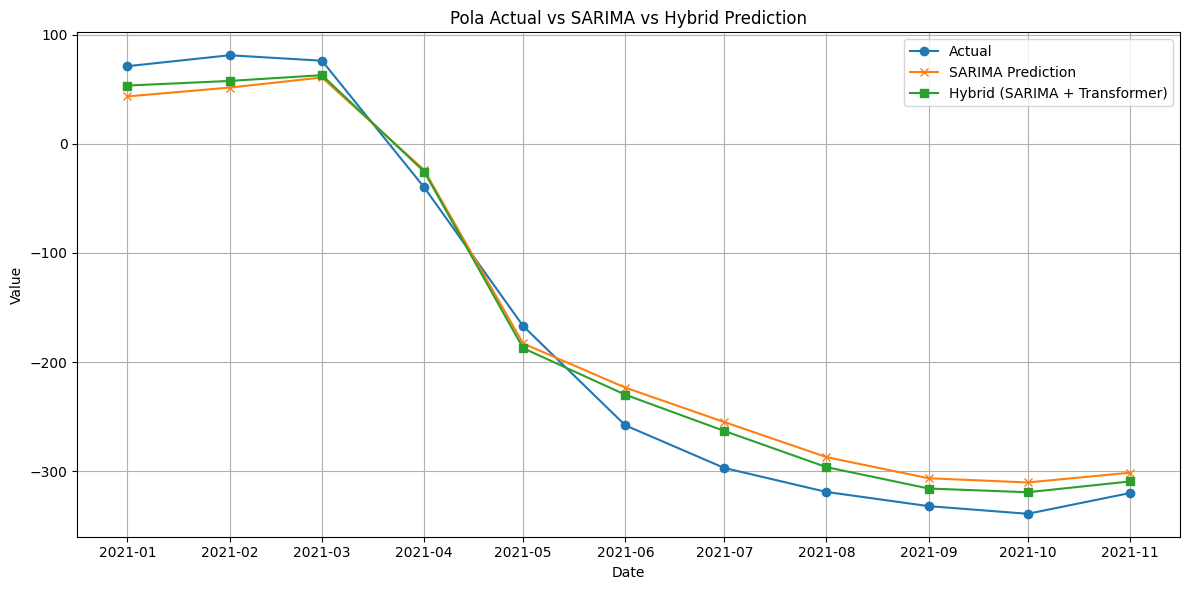

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data dari Excel
df = pd.read_excel("Forecast.xlsx")  # Ganti nama file sesuai file kamu

# 2. Hitung prediksi hybrid jika belum ada
df['Hybrid'] = df['SARIMA'] + df['Residual']

# 3. Ubah kolom tanggal jadi datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 4. Plot semua pola
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Actual'], label='Actual', marker='o')
plt.plot(df['Date'], df['SARIMA'], label='SARIMA Prediction', marker='x')
plt.plot(df['Date'], df['Hybrid'], label='Hybrid (SARIMA + Transformer)', marker='s')

# 5. Styling
plt.title('Pola Actual vs SARIMA vs Hybrid Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend() 
plt.tight_layout()
plt.show()
